In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Apr  7 19:14:00 2020

@author: fedor.goncharov.ol@gmail.com
"""

from importlib import reload 

import numpy as np
import numba as nb # for acceleration
import matplotlib.pyplot as plt




In [2]:
# procedure to compute Radon matrix via Siddon's algorithm

def line_projector(image, phi, shift, radius=1.0):
    
    # line is outside of the surrounding square
    if (shift > radius*np.sqrt(2)):
        return 0
    
    # image size
    npixels = image.shape[0]
    dx = 2*radius / npixels # pixel's side length 
    
    # set the geometry of the line
    line_center = np.array([[shift * np.cos(phi)], [shift * np.sin(phi)]])
    direction = np.array([[-np.sin(phi)], [np.cos(phi)]])
    dstep = dx / 2
    
    # set integration borders along the line
    lim_left = -np.sqrt(2*radius-shift**2)
    lim_right = -lim_left
    npoints = int(2*np.ceil(2*np.sqrt(2*radius-shift**2)/dstep) + 1)
    
    # get sampling points along the line
    line_points = line_center +  np.multiply(direction, np.linspace(lim_left, lim_right, npoints))
    
    line_pixels = (np.floor((line_points + radius)/dx)).astype(np.int32) # integers (i,j) of pixel coordinates
    line_pixels[1, :] = npixels - 1 - line_pixels[1, :]
    
    line_pixels = line_pixels[:, ((line_pixels[0] > -1)*(line_pixels[0] < npixels))
                              *((line_pixels[1] > -1)*(line_pixels[1] < npixels))]
    
    line_image_values = image[line_pixels[1, :], line_pixels[0, :]]
    proj_value = np.sum(line_image_values) * dstep

    return proj_value

@nb.njit
def siddon_line_projector(image, phi, shift, radius=1.0):
    """
        Sidon line projector - fast and exact execution algorithm
        for the ray transform along the line

        The code is not yet optimized - works not really fast 
    """
    
    c = np.cos(phi)
    s = np.sin(phi)
    R = radius
    sh = shift
    
    if (sh > R*np.sqrt(2)):
        return 0
    
    # get image size, pixel size
    npixels = image.shape[0]
    dx = 2*R / npixels # pixel's side length 
    
    # set the geometry of the line
    line_center = np.array([[sh * c], [sh * s]])
    direction = np.array([[-s], [c]])
    
    # 1. find intersections of the line with borders [-radius,radius]x[-radius, radius]
    n_intersect_pts = 0
    end_pts = np.zeros((2,2))
    
    # bottom border
    if (np.abs((sh + R*s)) < np.abs(c)*R):
        end_pts[n_intersect_pts, 0] = (sh + R*s)/c
        end_pts[n_intersect_pts, 1] = -R
        n_intersect_pts += 1 
        
    # right border
    if (np.abs((sh - R*c)) < np.abs(s)*R):
        end_pts[n_intersect_pts, 0] = R
        end_pts[n_intersect_pts, 1] = (sh - R*c)/s
        n_intersect_pts += 1 
            
            
    # top border
    if (np.abs((sh - R*s)) < np.abs(c)*R and n_intersect_pts < 2):
        end_pts[n_intersect_pts, 0] = (sh - R*s)/c
        end_pts[n_intersect_pts, 1] = R
        n_intersect_pts += 1 
            
    # left border
    if (np.abs((sh + R*c)) < np.abs(s)*R and n_intersect_pts < 2):
        end_pts[n_intersect_pts, 0] = -R
        end_pts[n_intersect_pts, 1] = (sh + R*c)/s
        n_intersect_pts += 1
            
    #assert (n_intersect_pts == 2), f"Failed to find 2 intersections. Line parameters: shift={sh}, phi={phi}, n_intersect={n_intersect_pts}"
    
    
    # check if points are not ordered according the direction - flip rows
    if (np.dot(end_pts[1, :] - end_pts[0, :], direction) < 0):
        tmp = end_pts[1].copy()
        end_pts[1] = end_pts[0]
        end_pts[0] = tmp
        #end_pts = np.flipud(end_pts, axis=0)
        #end_pts[[0, 1], :] = end_pts[[1, 0], :] 
    
        
    # 2.1 compute intersections x-axes
    x_max = np.max(end_pts[:, 0])
    x_min = np.min(end_pts[:, 0])
    dir_x = end_pts[1, 0] - end_pts[0, 0]
    
    x_axes = np.linspace(-R, R, npixels + 1)[1 : -1]
    x_coords_intersect = x_axes[(x_axes > x_min)*(x_axes < x_max)]
    x_pts_intersect = []
    for x in x_coords_intersect:
        alpha = (x - end_pts[0, 0])  / dir_x
        #assert ((alpha > 0.0) and (alpha < 1.0)), f"Failure to find intersection with line x={x}."
        y = end_pts[0, 1] * (1.0 - alpha) + end_pts[1, 1] * alpha
        x_pts_intersect.append([x, y, alpha]) 
    
    # 2.2 compute intersections y-axes
    y_max = np.max(end_pts[:, 1])
    y_min = np.min(end_pts[:, 1])
    dir_y = (end_pts[1, 1] - end_pts[0, 1])
    
    y_axes = np.linspace(-R, R, npixels + 1)[1 : -1]
    y_coords_intersect = y_axes[(y_axes > y_min)*(y_axes < y_max)]
    y_pts_intersect = []
    for y in y_coords_intersect:
        alpha = (y - end_pts[0, 1])  / dir_y
        #assert ((alpha > 0.0) & (alpha < 1.0))
        x = end_pts[0, 0] * (1.0 - alpha) + end_pts[1, 0] * alpha
        y_pts_intersect.append([x, y, alpha])
    
    # 3. merge ordered arrays of intersection points into one array of ordered intersections points
    #    increasing ordering ordering - column alpha
    
    # order both arrays x_pts_intersect, y_pts_intersect in increasing length with order
    if ((end_pts[1, 0] - end_pts[0, 0]) < 0.0):
        x_pts_intersect.reverse()
        
    if ((end_pts[1, 1] - end_pts[0, 1]) < 0.0):
        y_pts_intersect.reverse()
    
    len_x_intersect = len(x_pts_intersect)
    len_y_intersect = len(y_pts_intersect)
    ind_x = 0
    ind_y = 0
    pts_intersect = []
    
    # numba feature (list.insert is not implemented in Numba yet)
    pts_intersect.append([end_pts[0, 0], end_pts[0, 1],  0])
    
    
    while (ind_x < len_x_intersect and ind_y < len_y_intersect):
            
        if (x_pts_intersect[ind_x][-1] < y_pts_intersect[ind_y][-1]):
            pts_intersect.append(x_pts_intersect[ind_x])
            ind_x += 1
            continue
            
        if (x_pts_intersect[ind_x][-1] > y_pts_intersect[ind_y][-1]):
            pts_intersect.append(y_pts_intersect[ind_y])
            ind_y += 1
            continue
                
        if (x_pts_intersect[ind_x][-1] == y_pts_intersect[ind_y][-1]):
            pts_intersect.append(x_pts_intersect[ind_x])
            ind_x += 1
            ind_y += 1
            # continue 

    if (ind_x == len_x_intersect):
            
            assert ind_y < len_y_intersect, "Failed to attach the rest of ordered y-array"
            
            for ind in range(ind_y, len_y_intersect):
                pts_intersect.append(y_pts_intersect[ind])
            
    if (ind_y == len_y_intersect):
            assert ind_x < len_x_intersect, "Failed to attach the rest of ordered x-array"
            
            for ind in range(ind_x, len_x_intersect):
                pts_intersect.append(x_pts_intersect[ind])
                
            
    # add last point
    pts_intersect.append([end_pts[1, 0], end_pts[1, 1],  1])
    
    
    # 4. compute the value of the line integral
    ray_int_value = 0.0
    len_intersection = np.linalg.norm(end_pts[0] - end_pts[1])
    
    for ind in range(len(pts_intersect)-1):
        pix_len = (pts_intersect[ind + 1][2] - pts_intersect[ind][2])
        
        # get indicies of middle points
        mid_x = (pts_intersect[ind + 1][0] + pts_intersect[ind][0]) * 0.5
        mid_y = (pts_intersect[ind + 1][1] + pts_intersect[ind][1]) * 0.5        
        ind_x = int((mid_x + R) / dx) 
        ind_y = npixels - 1 - int((mid_y + R) / dx)
        
        im_val = 0.0
        if (ind_x >= 0 and ind_x < npixels and ind_y >= 0 and ind_y < npixels):
            im_val = image[ind_y, ind_x]
        
        ray_int_value += pix_len * im_val
        
    # computation is over
    return ray_int_value * len_intersection

@nb.njit
def matrixradon2d(npixels, ntheta, nshift, radius=1.0):
        
    # Radon matrix
    radon_matrix = np.zeros((ntheta*nshift, npixels**2))
        
    # init geometry/sizes
    dx = 2.0*radius / npixels # pixel's sidelength
    shifts = np.linspace(-radius + dx/2, radius-dx/2, nshift)
    theta = np.linspace(0, 2*np.pi, ntheta + 1)[:-1]
    
    for i_pixel in range(npixels**2):
        
        # pixel's coordinates
        pixel_coords = np.array([-radius + dx/2 + dx*(i_pixel % npixels),  
                                  radius - dx/2 - dx*(i_pixel // npixels)])
        
        # create one-pixel image 
        image = np.zeros(npixels**2)
        image[i_pixel] = 1.0
        image = np.reshape(image, (npixels, npixels))
    
        # compute matrix projection vector 
        proj_vector = np.zeros((ntheta, nshift))
        
        for i_theta in range(ntheta):
            
            # find shifts that are needed for computation for the pixel
            phi = theta[i_theta]
            normal = np.array([np.cos(phi), np.sin(phi)])
            pixel_shift = np.dot(pixel_coords, normal)
            
            supp_ind = (np.arange(nshift))[(np.fabs(shifts - pixel_shift) < dx*np.sqrt(2))]
            
            for i_shift in supp_ind:
                proj_vector[i_theta, i_shift] = siddon_line_projector(image, theta[i_theta], 
                                                          shifts[i_shift], radius)
        # return column
        radon_matrix[:, i_pixel] = np.reshape(proj_vector, ntheta*nshift)
        
    # return complete matrix
    return radon_matrix



In [3]:
# autocorrelation function

def acf(x, length=100):
    return np.array([1]+[np.corrcoef(x[:-i], x[i:])[0,1]  \
    for i in range(1, length)])

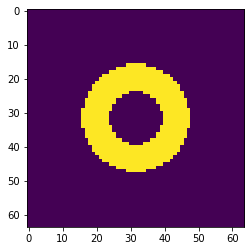

In [64]:
# phantom generation

size = 64

lin = np.linspace(-1., 1., size)
[XX, YY] = np.meshgrid(lin, lin)
RR = np.sqrt(XX**2 + YY**2)
image = np.zeros((size, size))
image[RR < 0.5] = 1.
image[RR < 0.25] = 0.
image += 1.

plt.figure()
plt.imshow(image)
plt.show()

phantom_vec = np.reshape(image, (size**2, 1))



In [5]:
# system matrix
system_matrix = matrixradon2d(size, size, size, 1.0)

In [6]:
# Fisher matrix for augmented data (F_aug = A_j / lambda_j)

sensitivity = np.sum(system_matrix, axis = 0, keepdims=True).T
diagonal = (1./phantom_vec) * sensitivity
fisher_augmented = np.diag(diagonal[:,0])

In [7]:
# Fisher matrix for observed data F_obs = A^T (1 / Lambda_i) A

diag_part = np.diag(1. / system_matrix.dot(phantom_vec)[:,0])
fisher_observed = system_matrix.T @ diag_part @ system_matrix

In [8]:
# SVD of the observed Fisher information matrix
U,S,V = np.linalg.svd(fisher_observed)

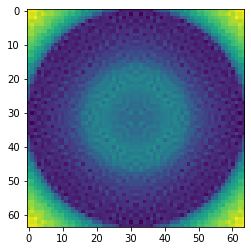

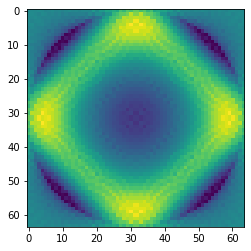

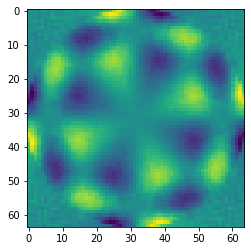

In [72]:
v1 = np.reshape(U[:, 0], (size, size))
v2 = np.reshape(U[:, 8], (size, size))
v3 = np.reshape(U[:, 50], (size, size))

plt.figure()
plt.imshow(v1)
plt.savefig('h0.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure()
plt.imshow(v2)
plt.savefig('h8.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure()
plt.imshow(v3)
plt.savefig('h50.png', dpi=300, bbox_inches='tight')
plt.show()

In [51]:
def et_gibbs_sampler(sinogram, observation_time, system_matrix, avg_scattered, 
                                gamma_pr_params, init, burn_in_size, sample_size):
    
    """
    Gibbs sampler for emission tomographies with
    prior Gamma distribution (alpha[shape], beta[scale]) in each pixel (i.e., without spatial regularizaiton).

    Description
    -------
    Each sample is an image generated in two steps:

        Step 1. Backprojection of observed data n_ij ~ p(n_ij | y, lambda),
        for each i - multinomial


        Step 2. Sampling of image lambda ~ p(lambda | n_ij, y), for each 
        j - Gamma()
        
    IMPORTANT: Sampled images are assumed to be square.
        
    Input
    -------
    sinogram : matrix of type (nshift, nphi) : photon counts along LORs

    observation_time : scalar : time for which the given photon counts were generated

    system_matrix : matrix of type (nshift*nphi, image_dim_size**2) : system matrix of observation data
    
    avg_scattered : matrix of type (nshift, nphi) : average number of scattered photons per LOR

    gamma_pr_params : tuple of type (float, float) : parameters (shape, scale) for Gamma-distribution prior

    init : matrix of type (image_dim_size, image_dim_size) : starting point for the MC

    burn_in_size : integer : samples for burn-in

    sample_size : integer : samples for output

    Output
    -------
    
        array of type (image_dim_size, image_dim_size, sample_size) containing all required samples

    """
    
    # read dimensions
    npixels = system_matrix.shape[1]
    nphi = sinogram.shape[0]
    nshift = sinogram.shape[1]
    
    gamma_pr_shape = gamma_pr_params[0] # alpha - shape parameter for prior Gamma distribution
    gamma_pr_scale = gamma_pr_params[1] # beta - scale parameter for prior Gamma distribution

    # vectorize input
    init_vec = np.reshape(init.copy(), (npixels, 1)) # copy of the init point
    cur_imag_vec = init_vec # initialize variable in a cycle for Gibbs sampler
    sinogram_vec = np.reshape(sinogram, (nshift*nphi, 1))
    avg_scattered_vec = np.reshape(avg_scattered, (nshift*nphi, 1))

    # preparation of constants Aj
    sensitivity_vec = system_matrix.sum(axis=0, keepdims=True).T # returns a column vector with sensitivities
    
    # reserve the output storage
    output_array = np.zeros((npixels, sample_size))

    # iteration loop start
    for it in range(burn_in_size + sample_size):
        
        # Step 1 : backprojection of observed data : n_ij ~ p(n_ij, y, lambda)
            backprojection = np.zeros((nshift*nphi, npixels)) # n_ij backprojected

        # assemble the probability matrix for multinomial distribution
            bprj_pmatrix_denominator = system_matrix.dot(cur_imag_vec) + avg_scattered_vec # sum_j a_ij * lambda_j + sc_i
            bprj_pmatrix_nominator = np.multiply(system_matrix, cur_imag_vec.T) # a_ij * lambda_j
            bprj_pmatrix = np.true_divide(bprj_pmatrix_nominator, bprj_pmatrix_denominator)
            scatter_p_vec = np.divide(avg_scattered_vec, bprj_pmatrix_denominator)
            bprj_pmatrix = np.append(bprj_pmatrix, scatter_p_vec, axis=1)
        
        # generate backprojected data n_ij, scattered photons
            for i in range(nshift*nphi):
                # incredibly important trick, otheriwse numpy generates error pval < 0, pval > 1 or pval = NaN
                last_nonzero_idx = (bprj_pmatrix[i, :].nonzero())[0][-1] # last non-zero element
                p_nonzero_array = bprj_pmatrix[i, :(last_nonzero_idx + 1)]
                backprojection[i, :] = np.concatenate(
                    (np.random.multinomial(sinogram_vec[i][0], p_nonzero_array),
                     np.zeros(npixels-last_nonzero_idx)))[:-1]
                
                #not used
                #backprojection[i, :] = (np.random.multinomial(sinogram_vec[i][0], bprj_pmatrix[i, :]))[:-1]
                     
            # end of Step 1

        # Step 2 : generate intensities using backprojection data : lambda ~ p(lambda | n_ij, y)
            gamma_pstr_shape = gamma_pr_shape + backprojection.sum(axis=0, keepdims=True).T
            gamma_pstr_scale = gamma_pr_scale / (gamma_pr_scale + sensitivity_vec*observation_time)
            cur_imag_vec = np.random.gamma(gamma_pstr_shape, gamma_pstr_scale) # generate random image
            
            # numba optimization (not used)
            #for p in range(npixels):
            #    gamma_pstr_scale = gamma_pr_scale / (gamma_pr_scale + sensitivity_vec[p]*observation_time)
            #    cur_imag_vec[p][0] = np.random.gamma(gamma_pstr_shape[p], gamma_pstr_scale)
            
            # end of Step 2

        # save the sample (if needed)
            if (it > burn_in_size-1):
                output_array[:, it-burn_in_size] = cur_imag_vec[:, 0]
            
            #print('Iteration ', it, ' is done.\n')
    
    # end of simulation
    return output_array


In [55]:
# gibbs sampler parameters 

observation_time_small = 1e2
observation_time_large = 1e10
gamma_prior_params = (1.,1.)
init = image


burn_in_size = 1000
sample_size = 2000


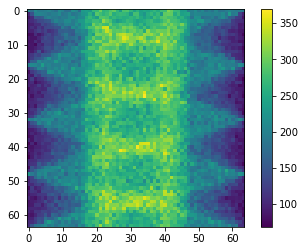

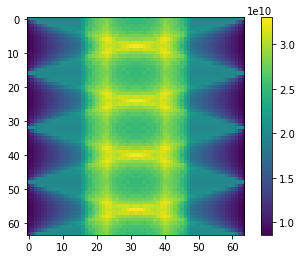

In [56]:
# generate noisy sinograms

def generate_noise_sino(sinogram, t):
    return np.random.poisson(t * sinogram)

sinogram_vec = system_matrix.dot(phantom_vec)
noise_sinogram_vec_small = generate_noise_sino(sinogram_vec, observation_time_small)
noise_sinogram_vec_large = generate_noise_sino(sinogram_vec, observation_time_large)
noise_sinogram_small = np.reshape(noise_sinogram_vec_small, (size, size))
noise_sinogram_large = np.reshape(noise_sinogram_vec_large, (size, size))

plt.imshow(noise_sinogram_small) # sinogram for t=1e2
plt.colorbar()
plt.show()

plt.imshow(noise_sinogram_large) # sinogram for t=1e10
plt.colorbar()
plt.show()


In [57]:
# generate samples for t=1e4,1e10 (quite long to wait ~ 2h on standard laptop)

posterior_sample_small = et_gibbs_sampler(noise_sinogram_small, observation_time_small,
                                                system_matrix, np.zeros((size, size)),
                                                gamma_prior_params, init, burn_in_size, sample_size)


posterior_sample_large = et_gibbs_sampler(noise_sinogram_large, observation_time_large,
                                                system_matrix, np.zeros((size, size)),
                                                gamma_prior_params, init, burn_in_size, sample_size)




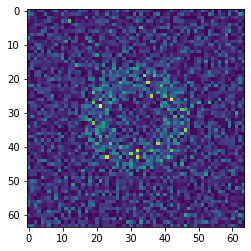

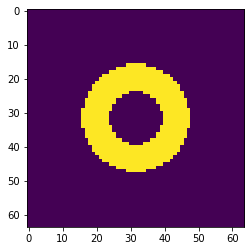

In [58]:
# example of samples

plt.imshow(np.reshape(posterior_sample_small[:, 0], (size, size)))
plt.show()

plt.imshow(np.reshape(posterior_sample_large[:, 0], (size, size)))
plt.show()


In [62]:


rates_theor = np.array([]) # theoretical mixing rates 
rates_num_small = np.array([])   # empirical mixing rates for smaller t=1e2
rates_num_large = np.array([])   # empirical mixing rates for larger t=1e10

n_eigvects = 200

for idx in range(n_eigvects):
    
    projector_vec = np.reshape(U[:, idx], (size*size, 1))
    nom = np.dot(projector_vec.T, np.linalg.solve(fisher_augmented, projector_vec))
    rate = 1. - S[idx] * nom # theoretical rate according to BvM theorem
    rates_theor = np.append(rates_theor, rate)
    print(f'{idx}th eigvect. : mixing rate: {rate[0][0]}')

    empirical_projections_small = np.array([])
    empirical_projections_large = np.array([])

    for i in range(sample_size):
        empirical_projections_small = np.append(empirical_projections_small, np.dot(posterior_sample_small[:, i], projector_vec[:]))
        empirical_projections_large = np.append(empirical_projections_large, np.dot(posterior_sample_large[:, i], projector_vec[:]))

    # autocovariance lag=1 = covariance = mixing rate
    correlations_small = acf(empirical_projections_small, length=2)
    correlations_large = acf(empirical_projections_large, length=2)
    rates_num_small = np.append(rates_num_small, correlations_small[1])
    rates_num_large = np.append(rates_num_large, correlations_large[1])
    


0th eigvect. : mixing rate:0.01614027746377389
1th eigvect. : mixing rate:0.5301760398782329
2th eigvect. : mixing rate:0.5301760398782334
3th eigvect. : mixing rate:0.6906501663944813
4th eigvect. : mixing rate:0.648924132704926
5th eigvect. : mixing rate:0.7562835028466526
6th eigvect. : mixing rate:0.7698141393031048
7th eigvect. : mixing rate:0.7698141393031046
8th eigvect. : mixing rate:0.8092673501893608
9th eigvect. : mixing rate:0.8078609031889523
10th eigvect. : mixing rate:0.8078609031889525
11th eigvect. : mixing rate:0.8166240146267669
12th eigvect. : mixing rate:0.8409527330836064
13th eigvect. : mixing rate:0.8372989041666357
14th eigvect. : mixing rate:0.8572227890590576
15th eigvect. : mixing rate:0.8411820271772528
16th eigvect. : mixing rate:0.8411820271772524
17th eigvect. : mixing rate:0.871189521525605
18th eigvect. : mixing rate:0.8711895215256054
19th eigvect. : mixing rate:0.8729826456957114
20th eigvect. : mixing rate:0.8659934215470428
21th eigvect. : mixing r

174th eigvect. : mixing rate:0.9489443455165812
175th eigvect. : mixing rate:0.9478256417887125
176th eigvect. : mixing rate:0.9458280346830695
177th eigvect. : mixing rate:0.9464339935883315
178th eigvect. : mixing rate:0.9464339935883316
179th eigvect. : mixing rate:0.9473013196780232
180th eigvect. : mixing rate:0.9473013196780229
181th eigvect. : mixing rate:0.9484072541729818
182th eigvect. : mixing rate:0.948285229010599
183th eigvect. : mixing rate:0.9476845443869131
184th eigvect. : mixing rate:0.9476845443869131
185th eigvect. : mixing rate:0.9497051597374568
186th eigvect. : mixing rate:0.9474634778681265
187th eigvect. : mixing rate:0.9474634778681265
188th eigvect. : mixing rate:0.9481421533631561
189th eigvect. : mixing rate:0.9474167522650513
190th eigvect. : mixing rate:0.9499783658649835
191th eigvect. : mixing rate:0.9499783658649835
192th eigvect. : mixing rate:0.949001490946058
193th eigvect. : mixing rate:0.9472873598887965
194th eigvect. : mixing rate:0.94866988355

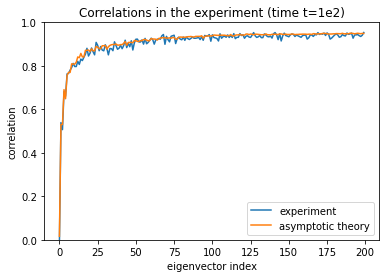

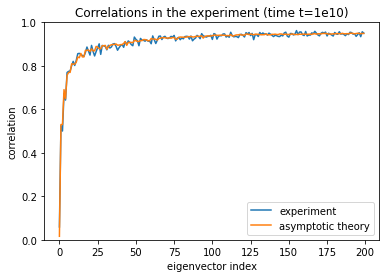

In [71]:
plt.figure()
plt.plot(rates_num_small)
plt.plot(rates_theor)
plt.legend(['experiment', 'asymptotic theory'])
plt.title('Correlations in the experiment (time t=1e2)')
plt.ylim((0,1))
plt.ylabel('correlation')
plt.xlabel('eigenvector index')
plt.savefig('mixing-rates-t1e2.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure()
plt.plot(rates_num_large)
plt.plot(rates_theor)
plt.legend(['experiment', 'asymptotic theory'])
plt.title('Correlations in the experiment (time t=1e10)')
plt.ylim((0,1))
plt.ylabel('correlation')
plt.xlabel('eigenvector index')
plt.savefig('mixing-rates-t1e10.png', dpi=300, bbox_inches='tight')
plt.show()